In [30]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [48]:
color = {"red": (255, 0, 0), "blue": (0, 0, 255), "green": (0, 255, 0), "white": (255, 255, 255)}
celeb_labels = ["Lionel_messi", "Maria Sharapova", "Roger Federer", "Serena williams", "Virat Kohli"]

face_cascade = cv2.CascadeClassifier('C:/Users/HP/OneDrive/Desktop/MACHINE LEARNING PROJECTS/FACE_RECOGNITION/opencv/haarcascades/haarcascade_frontalface_alt.xml')
eye_cascade = cv2.CascadeClassifier('C:/Users/HP/OneDrive/Desktop/MACHINE LEARNING PROJECTS/FACE_RECOGNITION/opencv/haarcascades/haarcascade_eye.xml')

path_to_data = 'C:/Users/HP/OneDrive/Desktop/MACHINE LEARNING PROJECTS/FACE_RECOGNITION/DATA/'
path_to_cr_data = 'C:/Users/HP/OneDrive/Desktop/MACHINE LEARNING PROJECTS/FACE_RECOGNITION/CROPPED_DATA/'

In [32]:
def detect_face_boundary(img, classifier, scaleFactor, minNeighbors, color, draw):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = classifier.detectMultiScale(gray_img, scaleFactor, minNeighbors)
    coords = []
    for (x, y, w, h) in features:
        if draw is True:
            cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
            plt.imshow(img)
        coords = [x, y, w, h]
    
    return coords

def detect_eye_boundary(cropped_img, classifier, scaleFactor, minNeighbors, color, draw):
    gray_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    features = classifier.detectMultiScale(gray_img, scaleFactor, minNeighbors)
    if(len(features) < 2):
        return False
    if draw is False:
        return True
    for (x, y, w, h) in features:
        cv2.rectangle(cropped_img, (x,y), (x+w, y+h), color, 2)
    return True

def crop_image_with_face(img, face_coords):
    x, y, h, w = face_coords
    crp_image = img[y:y+h,x:x+w]
    return crp_image

def get_cropped_image_with_two_eyes(image):
    face_coords = detect_face_boundary(image, face_cascade, 1.1, 2, color["white"], False)
    if len(face_coords) != 4:
        return
    cropped_img = crop_image_with_face(image, face_coords)
    if detect_eye_boundary(cropped_img, eye_cascade, 1.1, 2, color["green"], False) is True:
        return cropped_img

In [33]:
import pywt
def w2d(img,mode='haar',level=1):
    imArray=img
    #datatype conversion
    #convert to grayscale
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray = np.float32(imArray)
    imArray /=255;
    #copute coefficient
    coeffs = pywt.wavedec2(imArray,mode,level=level)
    
    #process coefficient
    coeffs_H = list(coeffs)
    coeffs_H[0] *=0;
    
    #reconstruction
    imArray_H = pywt.waverec2(coeffs_H,mode);
    imArray_H *=255;
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

In [34]:
def resize_image(image):
    # RESIZE THE IMAGE
    scalled_raw_img = cv2.resize(image,(32,32))
    # CONVERT THE IMAGE TO WAVELET FORM
    img_har = w2d(image,'db1',5)
    # THEN RESIZING THAT IMAGE AS WELL
    scalled_img_har = cv2.resize(img_har,(32,32))
    # THEN COMBINING BOTH THE COLORED IMAGES TO ON MATRICS => X
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
    return combined_img
    
    
def resize_to_32_by_32_image(celebrity_file_names_dict, class_dict):
    ## HERE WE ARE TRYING TO RESIZE ALL THE IMAGES IN A 32*32 MATRICS
    X = []
    y = []
    for celebrity_name , training_files in celebrity_file_names_dict.items():
        for training_image in training_files:
            img = cv2.imread(training_image)
            combined_img = resize_image(img)
            #HERE x IS THE COLEECTION OF ALL 46 CROPPED IMAGES OF ALL CELEBRITIES AND 
            #EACH ROW CONTAINS DATA FOR DIFFERENT PIXELS FOR DIFFERENT IMAGES
            # HERE X IS A LIST NOT A NUMPY ARRAY
            X.append(combined_img)
            #SIMILARLY  Y CONTAINS THE CLASSIFICATION VALUES  AS 0,1,2,3 FOR DIFFERENT CELEBRITY IMAGES
            # HERE Y IS A LIST NOT A NUMPY ARRAY
            y.append(class_dict[celebrity_name])
    X = np.array(X).reshape(len(X),len(X[0])).astype(float)
    return X,y

In [35]:
import os
import shutil
        
def prepare_dataset(path_to_data, path_to_cr_data):
    img_dirs = []
    for entry in os.scandir(path_to_data):
        if entry.is_dir():
            img_dirs.append(entry.path)
    
    if os.path.exists(path_to_cr_data):
        shutil.rmtree(path_to_cr_data)
    os.mkdir(path_to_cr_data)
    
    cropped_image_dirs=[]
    celebrity_file_names_dict={}
    
    for img_dir in img_dirs:
        count=1
        #get the celebrity name from the path 
        celebrity_name=img_dir.split('/')[-1]
        #now storing the name in dictionary : celebrity_file_names_dict !!! as a key keeping value empty
        celebrity_file_names_dict[celebrity_name]=[]
        #STEP 3: GETTING THE IMAGES AND CROPPING THEM
        for entry in os.scandir(img_dir):
            image_path = entry.path
            celeb_img = cv2.imread(image_path)
            if celeb_img is None:
                continue
            cropped_image = get_cropped_image_with_two_eyes(celeb_img)
            
            if cropped_image is not None:
                #Creating the folder with celebrity_name if folder does not exists
                cropped_folder=path_to_cr_data+celebrity_name
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                #STEP 4: giving a name to image
                cropped_file_name = celebrity_name + str(count) +".png"
                #STEP 5: generating path for the cropped image
                cropped_file_path = cropped_folder + "/" + cropped_file_name
                #STEP 6: STORING THE IMAGE "roi_color" IN THE PATH "cropped_filr_path"
                cv2.imwrite(cropped_file_path,cropped_image)
                #NOW STORE THE PATH OF THE CROPPED IMAGE IN CROPPED_FLE_NAMES_DICT
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count+=1#increment the count each time to generate new names
    
    celebrity_file_names_dict={}
    for img_dir in cropped_image_dirs:
        celebrity_name = img_dir.split('/')[-1]
        file_list = []
        for entry in os.scandir(img_dir):
            file_list.append(entry.path)
        celebrity_file_names_dict[celebrity_name] = file_list
    
    class_dict={}
    count=0
    for celebrity_name in celebrity_file_names_dict.keys():
        class_dict[celebrity_name] = count
        count+=1
    print("The mapping of celebrities :",class_dict)
    
    return celebrity_file_names_dict, class_dict

celebrity_file_names_dict, class_dict = prepare_dataset(path_to_data, path_to_cr_data)



The mapping of celebrities : {'lionel_messi': 0, 'maria_sharapova': 1, 'roger_federer': 2, 'serena_williams': 3, 'virat_kohli': 4}


In [37]:
X, y = resize_to_32_by_32_image(celebrity_file_names_dict, class_dict)

In [38]:
# from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [39]:
def preparePipelines():
    pipeline_logistic_regression = Pipeline([('scaler1', StandardScaler()), 
                                           ('pca1', PCA(n_components = 2)),
                                           ('lr_classifier', LogisticRegression(random_state=0))])
    pipeline_SVC = Pipeline([('scaler',StandardScaler()),
                             ('svc',SVC(kernel = 'rbf',C=10))])
    
    pipeline_decision_tree = Pipeline([('scaler2', StandardScaler()),
                                       ('pca2', PCA(n_components = 2)),
                                       ('dt_classifier', DecisionTreeClassifier())])
    
    pipeline_random_forest = Pipeline([('scaler3', StandardScaler()),
                                       ('pca3', PCA(n_components = 2)),
                                       ('rf_classifier', RandomForestClassifier())])
    
    pipelines = [pipeline_logistic_regression, pipeline_SVC, pipeline_decision_tree, pipeline_random_forest]
    return pipelines

In [40]:
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""
pipe_dict = {0 : 'Logisitc Regression',1 : 'SVC', 2 : 'Decision Tree', 3 : 'Random Forest'}
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

pipelines = preparePipelines()
for pipe in pipelines :
    pipe.fit(X_train, y_train)

for i, model in enumerate(pipelines):
    print("{} Test Accuracy : {} ".format(pipe_dict[i], model.score(X_test, y_test)))
    if model.score(X_test, y_test) > best_accuracy:
        best_accuracy = model.score(X_test, y_test)
        best_pipeline = model
        best_classifier = i
        
print("Classifier with best accuracy : {}".format(pipe_dict[best_classifier]))


Logisitc Regression Test Accuracy : 0.4418604651162791 
SVC Test Accuracy : 0.7441860465116279 
Decision Tree Test Accuracy : 0.3488372093023256 
Random Forest Test Accuracy : 0.3953488372093023 
Classifier with best accuracy : SVC


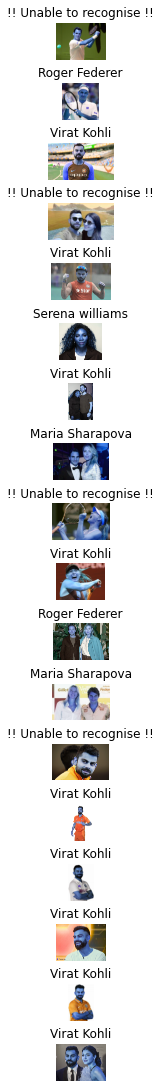

In [67]:
def test_images(test_image_dir):
    no_of_plots = 18
    plot = 0
    fig, ax = plt.subplots(no_of_plots, 1, figsize=(15,15), constrained_layout = True)
#     fig.tight_layout()
    for entry in os.scandir(test_image_dir):
        X_Test = []
        image_path = entry.path
        celeb_img = cv2.imread(image_path)
        plt.imshow(celeb_img)
        title = ""
        if celeb_img is None:
            title = "!! No Face Detected !!"
        else:
            cropped_image = get_cropped_image_with_two_eyes(celeb_img)
            if cropped_image is None:
                title = "!! Unable to recognise !!"
            else:
                combined_img = resize_image(cropped_image)
                X_Test.append(combined_img)
                X_Test_np = np.array(X_Test).reshape(len(X_Test),len(X_Test[0])).astype(float)
                y_Test_Result = pipelines[best_classifier].predict(X_Test_np)
                if(y_Test_Result[0] > 4):
                    title = "!! None !!"
                else:
                    title = celeb_labels[y_Test_Result[0]]
        plt.axis('off')
        ax[plot].imshow(celeb_img)
        ax[plot].set_title(title)
        ax[plot].set_axis_off()
        plot += 1

test_images('C:/Users/HP/OneDrive/Desktop/MACHINE LEARNING PROJECTS/FACE_RECOGNITION/TEST_DATA')